In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("=== LOADING E-COMMERCE DATA ===\n")

# Load both sheets
df_2009 = pd.read_excel('../data/raw/online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_2010 = pd.read_excel('../data/raw/online_retail_II.xlsx', sheet_name='Year 2010-2011')

print(f"2009-2010 sheet: {len(df_2009):,} rows")
print(f"2010-2011 sheet: {len(df_2010):,} rows")

# Combine both sheets
df = pd.concat([df_2009, df_2010], ignore_index=True)
print(f"\nCombined dataset: {len(df):,} rows")

print("\n=== COLUMN NAMES ===")
print(df.columns.tolist())

print("\n=== FIRST 10 ROWS ===")
print(df.head(10))

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== BASIC INFO ===")
print(df.info())

=== LOADING E-COMMERCE DATA ===

2009-2010 sheet: 525,461 rows
2010-2011 sheet: 541,910 rows

Combined dataset: 1,067,371 rows

=== COLUMN NAMES ===
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

=== FIRST 10 ROWS ===
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5  489434     22064           PINK DOUGHNUT TRINKET POT         24   
6  489434     21871                  SAVE THE PLANET MUG        24   
7  489434     21523   FANCY FONT HOME SWEET HOME DOORMAT        10   
8  489435     22350                            CAT BOWL         12   
9  489435     22349       

In [3]:
print("=== DATA QUALITY ANALYSIS ===\n")

# Missing values
print("MISSING VALUES:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Missing', ascending=False)
print(missing_df)

print("\n" + "="*60)
print("UNIQUE VALUES:")
print(f"Unique Invoices: {df['Invoice'].nunique():,}")
print(f"Unique Customers: {df['Customer ID'].nunique():,}")
print(f"Unique Products: {df['StockCode'].nunique():,}")
print(f"Unique Countries: {df['Country'].nunique():,}")

print("\n" + "="*60)
print("DATE RANGE:")
print(f"First transaction: {df['InvoiceDate'].min()}")
print(f"Last transaction: {df['InvoiceDate'].max()}")
print(f"Time span: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days} days")

print("\n" + "="*60)
print("QUANTITY ANALYSIS:")
print(df['Quantity'].describe())
print(f"\nNegative quantities (returns): {(df['Quantity'] < 0).sum():,}")
print(f"Zero quantities: {(df['Quantity'] == 0).sum():,}")

print("\n" + "="*60)
print("PRICE ANALYSIS:")
print(df['Price'].describe())
print(f"\nNegative prices: {(df['Price'] < 0).sum():,}")
print(f"Zero prices: {(df['Price'] == 0).sum():,}")

print("\n" + "="*60)
print("TOP 10 COUNTRIES:")
print(df['Country'].value_counts().head(10))

print("\n" + "="*60)
print("SAMPLE OF CANCELLED INVOICES (if any):")
cancelled = df[df['Invoice'].astype(str).str.startswith('C')]
print(f"Cancelled transactions: {len(cancelled):,}")
if len(cancelled) > 0:
    print(cancelled.head())

=== DATA QUALITY ANALYSIS ===

MISSING VALUES:
             Missing  Percentage
Customer ID   243007   22.766873
Description     4382    0.410541
Invoice            0    0.000000
StockCode          0    0.000000
Quantity           0    0.000000
InvoiceDate        0    0.000000
Price              0    0.000000
Country            0    0.000000

UNIQUE VALUES:
Unique Invoices: 53,628
Unique Customers: 5,942
Unique Products: 5,305
Unique Countries: 43

DATE RANGE:
First transaction: 2009-12-01 07:45:00
Last transaction: 2011-12-09 12:50:00
Time span: 738 days

QUANTITY ANALYSIS:
count    1.067371e+06
mean     9.938898e+00
std      1.727058e+02
min     -8.099500e+04
25%      1.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      8.099500e+04
Name: Quantity, dtype: float64

Negative quantities (returns): 22,950
Zero quantities: 0

PRICE ANALYSIS:
count    1.067371e+06
mean     4.649388e+00
std      1.235531e+02
min     -5.359436e+04
25%      1.250000e+00
50%      2.100000e+00
75% 

In [4]:
print("=== DATA CLEANING ===\n")

# Starting point
print(f"Starting rows: {len(df):,}")

# Step 1: Remove rows without Customer ID
df_clean = df[df['Customer ID'].notna()].copy()
print(f"After removing missing Customer IDs: {len(df_clean):,} rows ({len(df_clean)/len(df)*100:.1f}%)")

# Step 2: Remove cancelled invoices (Invoice starts with 'C')
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]
print(f"After removing cancelled invoices: {len(df_clean):,} rows")

# Step 3: Remove negative quantities
df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"After removing negative quantities: {len(df_clean):,} rows")

# Step 4: Remove negative and zero prices
df_clean = df_clean[df_clean['Price'] > 0]
print(f"After removing bad prices: {len(df_clean):,} rows")

# Step 5: Calculate TotalAmount (Quantity × Price)
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']
print(f"\n✓ Added TotalAmount column")

# Step 6: Convert Customer ID to integer
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)
print(f"✓ Converted Customer ID to integer")

print("\n" + "="*60)
print("CLEANED DATASET SUMMARY:")
print(f"Final rows: {len(df_clean):,}")
print(f"Unique customers: {df_clean['Customer ID'].nunique():,}")
print(f"Unique invoices: {df_clean['Invoice'].nunique():,}")
print(f"Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")
print(f"Total revenue: ${df_clean['TotalAmount'].sum():,.2f}")

print("\n" + "="*60)
print("SAMPLE OF CLEANED DATA:")
print(df_clean.head(10))

print("\n" + "="*60)
print("CHECKING FOR REMAINING ISSUES:")
print(f"Null values: {df_clean.isnull().sum().sum()}")
print(f"Negative quantities: {(df_clean['Quantity'] < 0).sum()}")
print(f"Negative prices: {(df_clean['Price'] < 0).sum()}")
print(f"Zero amounts: {(df_clean['TotalAmount'] == 0).sum()}")

# Save cleaned data
df_clean.to_csv('../data/processed/cleaned_transactions.csv', index=False)
print("\n✓ Saved cleaned data to data/processed/cleaned_transactions.csv")

=== DATA CLEANING ===

Starting rows: 1,067,371
After removing missing Customer IDs: 824,364 rows (77.2%)
After removing cancelled invoices: 805,620 rows
After removing negative quantities: 805,620 rows
After removing bad prices: 805,549 rows

✓ Added TotalAmount column
✓ Converted Customer ID to integer

CLEANED DATASET SUMMARY:
Final rows: 805,549
Unique customers: 5,878
Unique invoices: 36,969
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Total revenue: $17,743,429.18

SAMPLE OF CLEANED DATA:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5  489434     22064           PINK DOUGHNUT TRINKET POT         24   


In [5]:
print("=== RFM ANALYSIS ===\n")

# Set analysis date (day after last transaction)
analysis_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Analysis date: {analysis_date}")
print(f"Last transaction: {df_clean['InvoiceDate'].max()}")

print("\n" + "="*60)
print("CALCULATING RFM METRICS FOR EACH CUSTOMER...")

# Calculate RFM
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency (unique invoices)
    'TotalAmount': 'sum'   # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(f"\n✓ Calculated RFM for {len(rfm):,} customers")

print("\n" + "="*60)
print("RFM STATISTICS:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

print("\n" + "="*60)
print("SAMPLE RFM DATA:")
print(rfm.head(10))

print("\n" + "="*60)
print("DISTRIBUTION CHECKS:")
print(f"Recency range: {rfm['Recency'].min()} to {rfm['Recency'].max()} days")
print(f"Frequency range: {rfm['Frequency'].min()} to {rfm['Frequency'].max()} purchases")
print(f"Monetary range: ${rfm['Monetary'].min():.2f} to ${rfm['Monetary'].max():,.2f}")

print("\n" + "="*60)
print("TOP 10 CUSTOMERS BY SPENDING:")
top_customers = rfm.nlargest(10, 'Monetary')[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
print(top_customers)

print("\n" + "="*60)
print("CHECKING FOR OUTLIERS:")
print(f"Customers with Frequency > 100: {(rfm['Frequency'] > 100).sum()}")
print(f"Customers with Monetary > $50,000: {(rfm['Monetary'] > 50000).sum()}")

# Save RFM data
rfm.to_csv('../data/processed/rfm_data.csv', index=False)
print("\n✓ Saved RFM data to data/processed/rfm_data.csv")

=== RFM ANALYSIS ===

Analysis date: 2011-12-10 12:50:00
Last transaction: 2011-12-09 12:50:00

CALCULATING RFM METRICS FOR EACH CUSTOMER...

✓ Calculated RFM for 5,878 customers

RFM STATISTICS:
           Recency    Frequency       Monetary
count  5878.000000  5878.000000    5878.000000
mean    201.331916     6.289384    3018.616737
std     209.338707    13.009406   14737.731040
min       1.000000     1.000000       2.950000
25%      26.000000     1.000000     348.762500
50%      96.000000     3.000000     898.915000
75%     380.000000     7.000000    2307.090000
max     739.000000   398.000000  608821.650000

SAMPLE RFM DATA:
   CustomerID  Recency  Frequency  Monetary
0       12346      326         12  77556.46
1       12347        2          8   5633.32
2       12348       75          5   2019.40
3       12349       19          4   4428.69
4       12350      310          1    334.40
5       12351      375          1    300.93
6       12352       36         10   2849.84
7       123

=== RFM VISUALIZATIONS ===



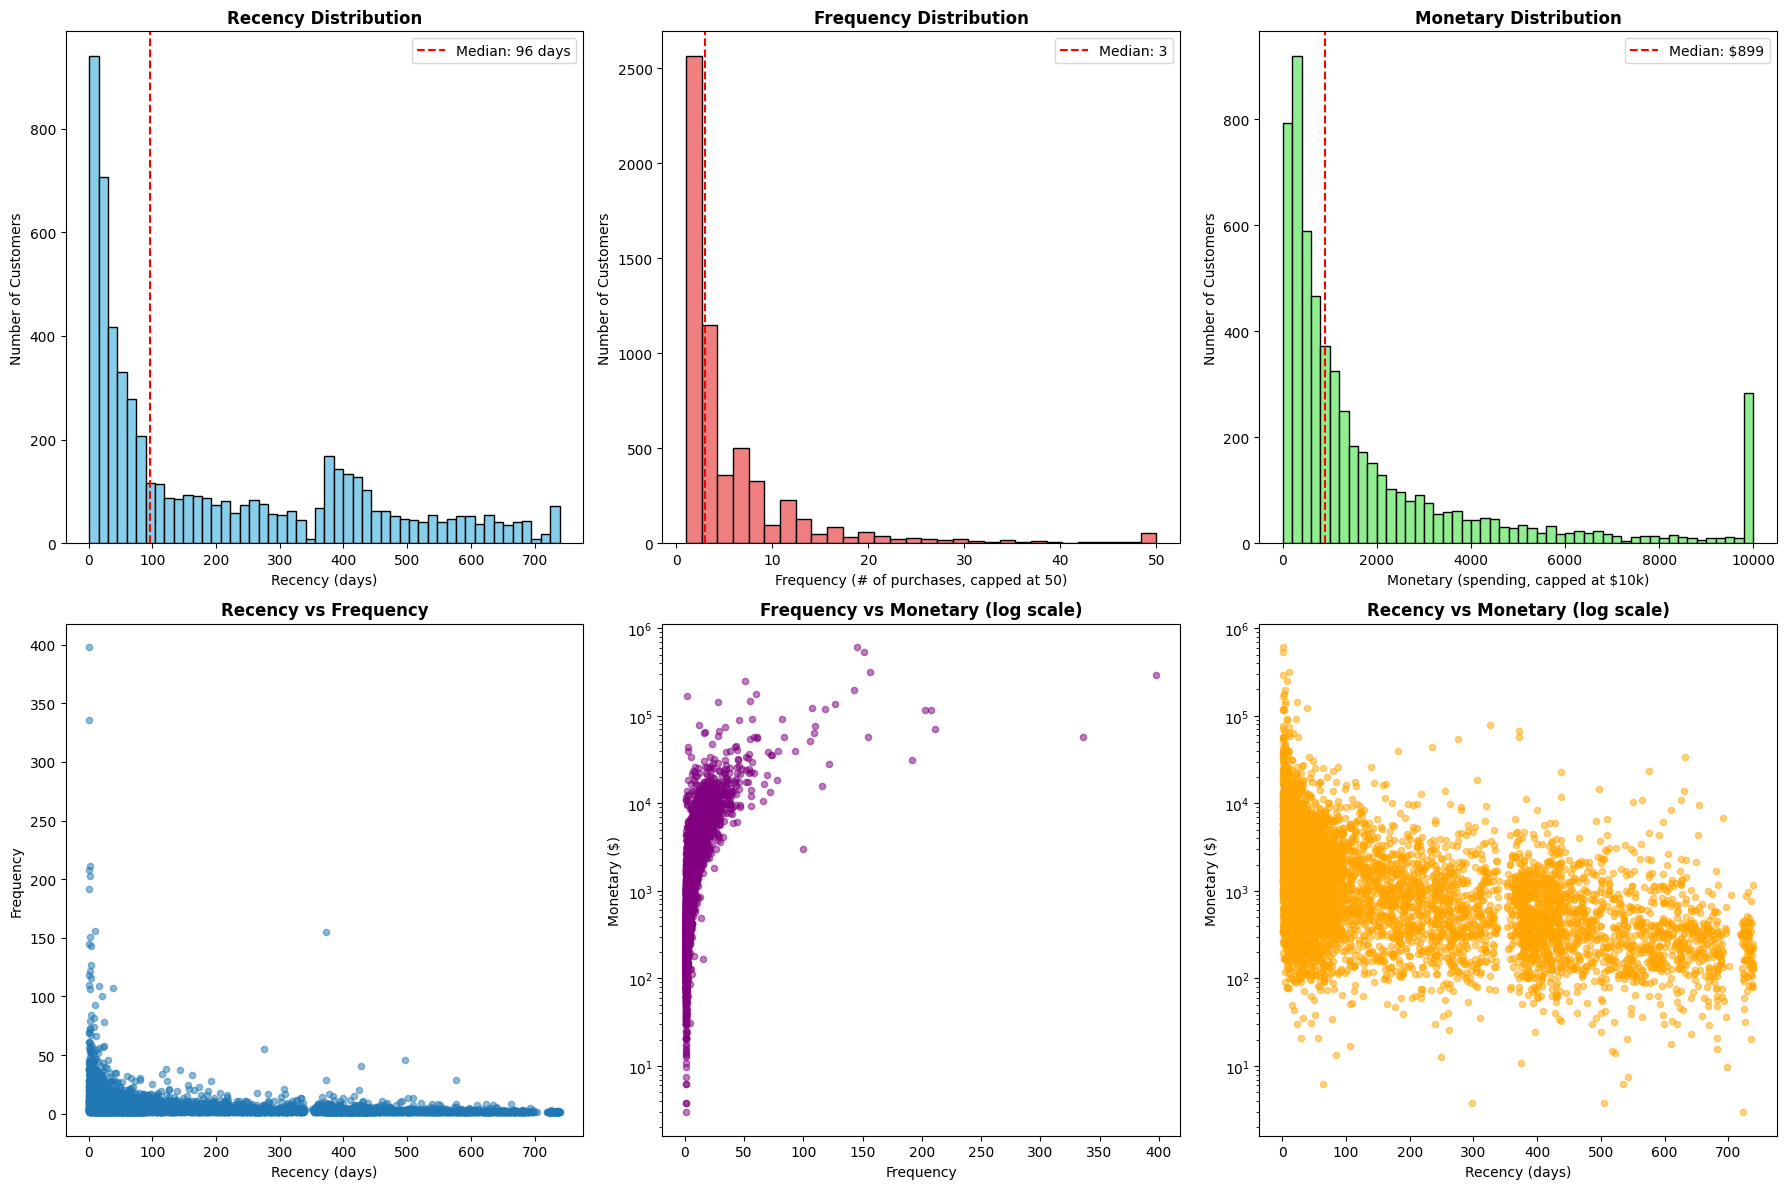

✓ Saved RFM distribution plots


In [6]:
print("=== RFM VISUALIZATIONS ===\n")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Recency Distribution
axes[0, 0].hist(rfm['Recency'], bins=50, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Recency Distribution', fontweight='bold')
axes[0, 0].axvline(rfm['Recency'].median(), color='red', linestyle='--', label=f'Median: {rfm["Recency"].median():.0f} days')
axes[0, 0].legend()

# 2. Frequency Distribution (capped at 50 for visualization)
freq_capped = rfm['Frequency'].clip(upper=50)
axes[0, 1].hist(freq_capped, bins=30, edgecolor='black', color='lightcoral')
axes[0, 1].set_xlabel('Frequency (# of purchases, capped at 50)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('Frequency Distribution', fontweight='bold')
axes[0, 1].axvline(rfm['Frequency'].median(), color='red', linestyle='--', label=f'Median: {rfm["Frequency"].median():.0f}')
axes[0, 1].legend()

# 3. Monetary Distribution (capped at $10k for visualization)
monetary_capped = rfm['Monetary'].clip(upper=10000)
axes[0, 2].hist(monetary_capped, bins=50, edgecolor='black', color='lightgreen')
axes[0, 2].set_xlabel('Monetary (spending, capped at $10k)')
axes[0, 2].set_ylabel('Number of Customers')
axes[0, 2].set_title('Monetary Distribution', fontweight='bold')
axes[0, 2].axvline(rfm['Monetary'].median(), color='red', linestyle='--', label=f'Median: ${rfm["Monetary"].median():.0f}')
axes[0, 2].legend()

# 4. Recency vs Frequency
axes[1, 0].scatter(rfm['Recency'], rfm['Frequency'], alpha=0.5, s=20)
axes[1, 0].set_xlabel('Recency (days)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Recency vs Frequency', fontweight='bold')

# 5. Frequency vs Monetary (log scale for better visualization)
axes[1, 1].scatter(rfm['Frequency'], rfm['Monetary'], alpha=0.5, s=20, color='purple')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Monetary ($)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Frequency vs Monetary (log scale)', fontweight='bold')

# 6. Recency vs Monetary (log scale)
axes[1, 2].scatter(rfm['Recency'], rfm['Monetary'], alpha=0.5, s=20, color='orange')
axes[1, 2].set_xlabel('Recency (days)')
axes[1, 2].set_ylabel('Monetary ($)')
axes[1, 2].set_yscale('log')
axes[1, 2].set_title('Recency vs Monetary (log scale)', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/rfm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved RFM distribution plots")

=== K-MEANS CLUSTERING ===

✓ Standardized RFM features
Features shape: (5878, 3)

Testing different numbers of clusters...
k=2: Inertia=11114, Silhouette=0.4270
k=3: Inertia=8016, Silhouette=0.4426
k=4: Inertia=5473, Silhouette=0.4109
k=5: Inertia=4431, Silhouette=0.3904
k=6: Inertia=3668, Silhouette=0.3870
k=7: Inertia=3121, Silhouette=0.3862
k=8: Inertia=2605, Silhouette=0.3698
k=9: Inertia=2295, Silhouette=0.3649
k=10: Inertia=2050, Silhouette=0.3518


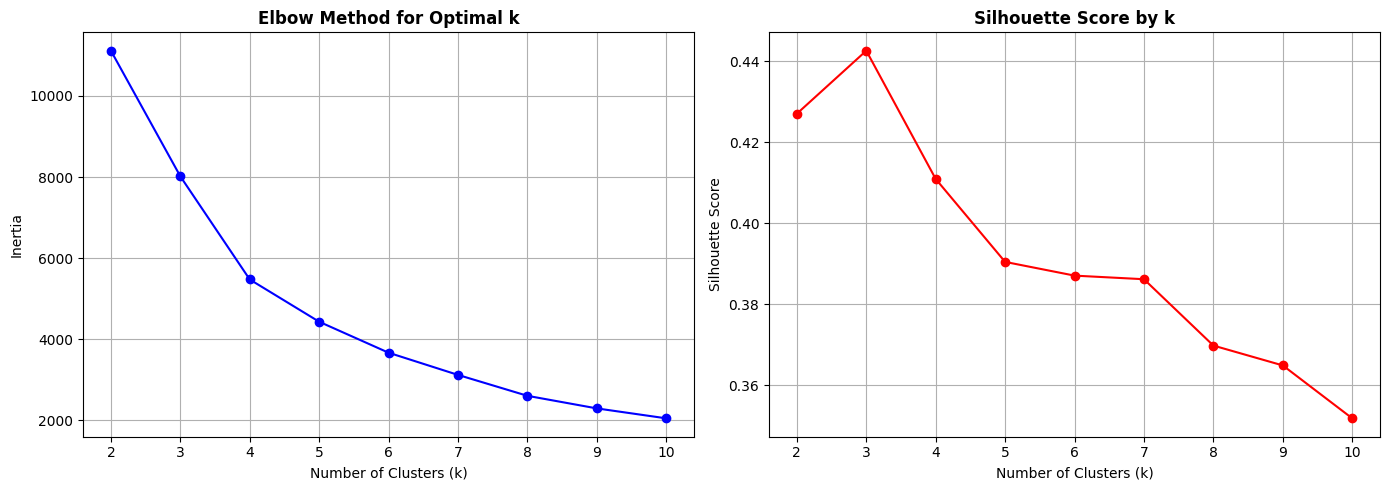


✓ Saved elbow analysis plot


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("=== K-MEANS CLUSTERING ===\n")

# Prepare data for clustering
# We'll use log transformation for Monetary due to extreme outliers
rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()
rfm_clustering['Monetary_Log'] = np.log1p(rfm_clustering['Monetary'])  # log(1+x) to handle zeros

# Drop original Monetary, keep log version
rfm_features = rfm_clustering[['Recency', 'Frequency', 'Monetary_Log']]

# Standardize features (important for K-means!)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

print("✓ Standardized RFM features")
print(f"Features shape: {rfm_scaled.shape}")

# Find optimal number of clusters using Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("\nTesting different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"k={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={sil_score:.4f}")

# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k', fontweight='bold')
ax1.grid(True)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by k', fontweight='bold')
ax2.grid(True)

plt.tight_layout()
plt.savefig('../data/processed/elbow_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved elbow analysis plot")

In [9]:
print("=== FINAL CUSTOMER SEGMENTATION (k=3) ===\n")

# Fit final model with k=3
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled)

print(f"✓ Created {optimal_k} customer segments")

print("\n" + "="*60)
print("CLUSTER SIZES:")
cluster_counts = rfm['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = (count / len(rfm)) * 100
    print(f"Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")

print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS (MEAN VALUES):")
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_summary)

print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS (MEDIAN VALUES):")
cluster_summary_median = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].median()
print(cluster_summary_median)

print("\n" + "="*60)
print("DETAILED CLUSTER ANALYSIS:")
for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    print(f"\n CLUSTER {cluster_id} ({len(cluster_data)} customers):")
    print(f"   Recency: {cluster_data['Recency'].mean():.0f} days (median: {cluster_data['Recency'].median():.0f})")
    print(f"   Frequency: {cluster_data['Frequency'].mean():.1f} purchases (median: {cluster_data['Frequency'].median():.0f})")
    print(f"   Monetary: ${cluster_data['Monetary'].mean():,.0f} (median: ${cluster_data['Monetary'].median():.0f})")
    print(f"   Total Revenue: ${cluster_data['Monetary'].sum():,.0f}")
    
    # Customer examples
    print(f"   Sample customers:")
    sample = cluster_data.nlargest(3, 'Monetary')[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
    for idx, row in sample.iterrows():
        print(f"      Customer {row['CustomerID']}: R={row['Recency']}, F={row['Frequency']}, M=${row['Monetary']:,.0f}")

# Save segmented data
rfm.to_csv('../data/processed/rfm_segmented.csv', index=False)
print("\n✓ Saved segmented data to data/processed/rfm_segmented.csv")

=== FINAL CUSTOMER SEGMENTATION (k=3) ===

✓ Created 3 customer segments

CLUSTER SIZES:
Cluster 0: 2,283 customers (38.8%)
Cluster 1: 3,571 customers (60.8%)
Cluster 2: 24 customers (0.4%)

CLUSTER CHARACTERISTICS (MEAN VALUES):
            Recency   Frequency       Monetary
Cluster                                       
0        418.109943    1.894875     543.414701
1         63.951274    8.118734    3714.718425
2         21.416667  152.125000  134898.080083

CLUSTER CHARACTERISTICS (MEDIAN VALUES):
         Recency  Frequency  Monetary
Cluster                              
0          413.0        1.0    327.38
1           36.0        5.0   1686.12
2            3.0      124.5  73360.47

DETAILED CLUSTER ANALYSIS:

 CLUSTER 0 (2283 customers):
   Recency: 418 days (median: 413)
   Frequency: 1.9 purchases (median: 1)
   Monetary: $543 (median: $327)
   Total Revenue: $1,240,616
   Sample customers:
      Customer 15760.0: R=631.0, F=2.0, M=$13,916
      Customer 12918.0: R=626.0, F=1.

=== VISUALIZING CUSTOMER SEGMENTS ===



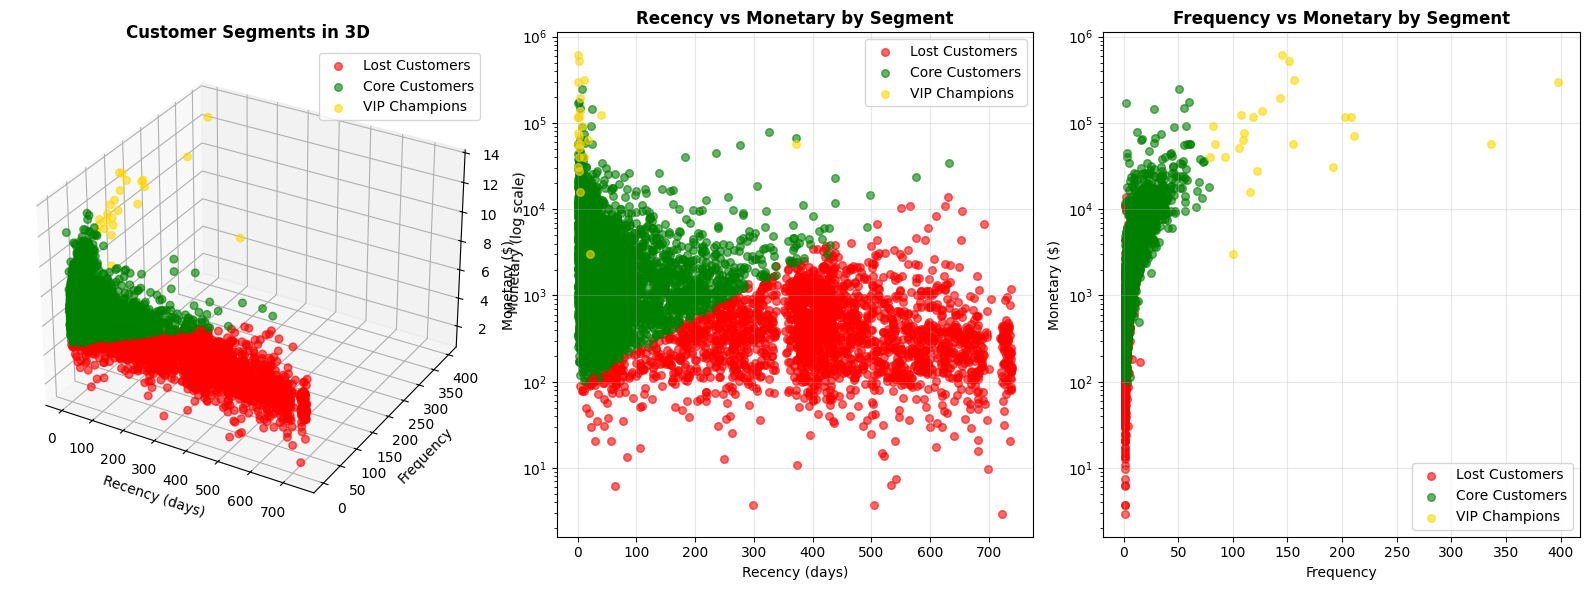

✓ Saved customer segment visualizations


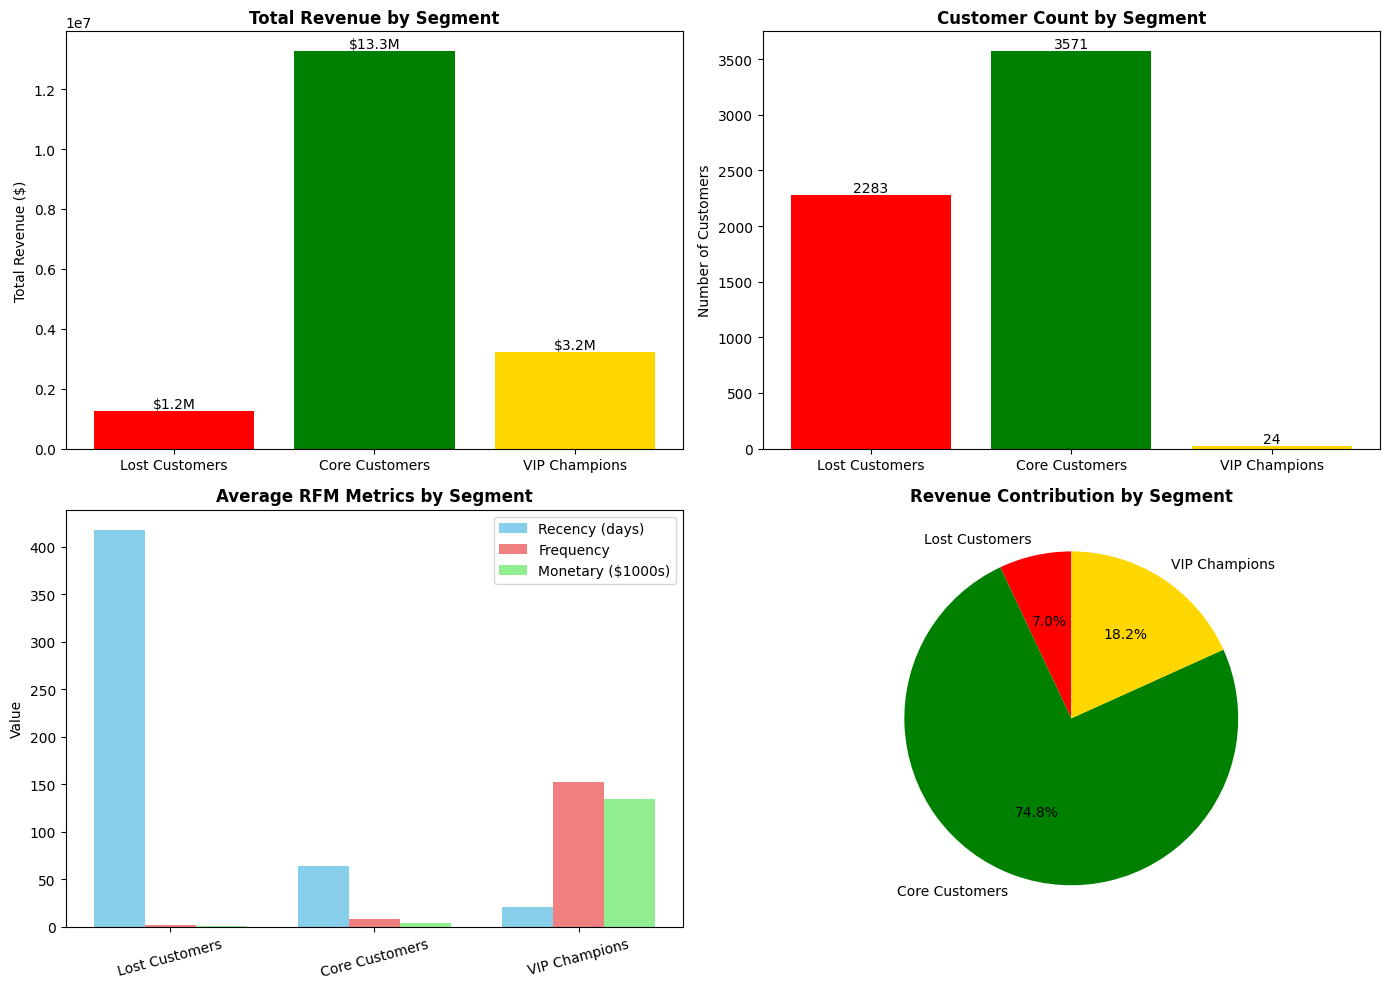

✓ Saved segment summary visualizations

=== SEGMENTATION COMPLETE! ===


In [10]:
print("=== VISUALIZING CUSTOMER SEGMENTS ===\n")

# Create 3D scatter plot
fig = plt.figure(figsize=(16, 6))

# Plot 1: 3D scatter
ax1 = fig.add_subplot(131, projection='3d')
colors = ['red', 'green', 'gold']
cluster_names = ['Lost Customers', 'Core Customers', 'VIP Champions']

for i in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == i]
    ax1.scatter(cluster_data['Recency'], 
               cluster_data['Frequency'], 
               np.log1p(cluster_data['Monetary']),  # Log scale for visibility
               c=colors[i], label=cluster_names[i], alpha=0.6, s=30)

ax1.set_xlabel('Recency (days)')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary (log scale)')
ax1.set_title('Customer Segments in 3D', fontweight='bold')
ax1.legend()

# Plot 2: Recency vs Monetary (2D)
ax2 = fig.add_subplot(132)
for i in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == i]
    ax2.scatter(cluster_data['Recency'], 
               cluster_data['Monetary'],
               c=colors[i], label=cluster_names[i], alpha=0.6, s=30)

ax2.set_xlabel('Recency (days)')
ax2.set_ylabel('Monetary ($)')
ax2.set_yscale('log')
ax2.set_title('Recency vs Monetary by Segment', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Frequency vs Monetary (2D)
ax3 = fig.add_subplot(133)
for i in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == i]
    ax3.scatter(cluster_data['Frequency'], 
               cluster_data['Monetary'],
               c=colors[i], label=cluster_names[i], alpha=0.6, s=30)

ax3.set_xlabel('Frequency')
ax3.set_ylabel('Monetary ($)')
ax3.set_yscale('log')
ax3.set_title('Frequency vs Monetary by Segment', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/customer_segments.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved customer segment visualizations")

# Summary statistics visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Revenue by segment
revenue_by_cluster = rfm.groupby('Cluster')['Monetary'].sum()
ax = axes[0, 0]
bars = ax.bar(range(optimal_k), revenue_by_cluster.values, color=colors)
ax.set_xticks(range(optimal_k))
ax.set_xticklabels(cluster_names)
ax.set_ylabel('Total Revenue ($)')
ax.set_title('Total Revenue by Segment', fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height/1e6:.1f}M', ha='center', va='bottom')

# Customer count by segment
ax = axes[0, 1]
bars = ax.bar(range(optimal_k), cluster_counts.values, color=colors)
ax.set_xticks(range(optimal_k))
ax.set_xticklabels(cluster_names)
ax.set_ylabel('Number of Customers')
ax.set_title('Customer Count by Segment', fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

# Average metrics by segment
ax = axes[1, 0]
cluster_means = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
x = np.arange(len(cluster_names))
width = 0.25
ax.bar(x - width, cluster_means['Recency'], width, label='Recency (days)', color='skyblue')
ax.bar(x, cluster_means['Frequency'], width, label='Frequency', color='lightcoral')
ax.bar(x + width, cluster_means['Monetary']/1000, width, label='Monetary ($1000s)', color='lightgreen')
ax.set_xticks(x)
ax.set_xticklabels(cluster_names, rotation=15)
ax.set_ylabel('Value')
ax.set_title('Average RFM Metrics by Segment', fontweight='bold')
ax.legend()

# Pie chart - revenue contribution
ax = axes[1, 1]
revenue_pct = (revenue_by_cluster / revenue_by_cluster.sum()) * 100
ax.pie(revenue_pct, labels=cluster_names, autopct='%1.1f%%', 
       colors=colors, startangle=90)
ax.set_title('Revenue Contribution by Segment', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/segment_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved segment summary visualizations")
print("\n=== SEGMENTATION COMPLETE! ===")

In [11]:
import plotly.graph_objects as go

print("=== CREATING INTERACTIVE 3D VISUALIZATION ===\n")

# Create interactive 3D scatter plot with Plotly
fig = go.Figure()

colors_plotly = ['red', 'green', 'gold']
cluster_names = ['Lost Customers', 'Core Customers', 'VIP Champions']

for i in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == i]
    
    # Create hover text with customer details
    hover_text = [
        f"Customer ID: {cid}<br>" +
        f"Recency: {r} days<br>" +
        f"Frequency: {f} purchases<br>" +
        f"Monetary: ${m:,.0f}<br>" +
        f"Segment: {cluster_names[i]}"
        for cid, r, f, m in zip(
            cluster_data['CustomerID'],
            cluster_data['Recency'],
            cluster_data['Frequency'],
            cluster_data['Monetary']
        )
    ]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data['Recency'],
        y=cluster_data['Frequency'],
        z=np.log1p(cluster_data['Monetary']),  # Log scale for better visualization
        mode='markers',
        name=cluster_names[i],
        marker=dict(
            size=5,
            color=colors_plotly[i],
            opacity=0.7,
            line=dict(width=0.5, color='white')
        ),
        text=hover_text,
        hovertemplate='%{text}<extra></extra>'
    ))

fig.update_layout(
    title='Interactive Customer Segmentation (3D)',
    scene=dict(
        xaxis_title='Recency (days)',
        yaxis_title='Frequency (purchases)',
        zaxis_title='Monetary (log scale)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1000,
    height=700,
    showlegend=True
)

fig.show()

# Save as HTML for dashboard
fig.write_html('../data/processed/interactive_3d_segments.html')
print("✓ Saved interactive 3D plot as HTML")
print("✓ You can rotate, zoom, and hover over points!")

=== CREATING INTERACTIVE 3D VISUALIZATION ===



✓ Saved interactive 3D plot as HTML
✓ You can rotate, zoom, and hover over points!
